In [2]:
import networkx as nx
import random
import matplotlib.pyplot as plt

from networkx.drawing.nx_agraph import graphviz_layout, to_agraph

from itertools import combinations

In [3]:
node_size = 300
font_size = 13
width = 5

In [4]:
init = 'initial'
final = 'final'
label = 'label'
in_encoding = 'in_encoding'
in_current = 'in_current'
children = 'children'

In [5]:
def plot_encoding_tree(t, figsize=None, transition=None, title=None, plot_encoding=False):
    figsize = (12, 6) if not figsize else figsize
    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    if title: 
        plt.title(title)
    plt.axis('off')
    pos = graphviz_layout(t, prog='dot')
    if transition:
        plt.title(transition)
#     pos = nx.spectral_layout(t)
    if plot_encoding:
        nx.draw_networkx_nodes(t, pos, nodelist=[u for u in t if t.nodes[u][in_encoding]], 
                           node_size=node_size*2, node_color='white',linewidths=width, edgecolors='m')
    else:
        # plot the complement
        nx.draw_networkx_nodes(t, pos, nodelist=[u for u in t if not t.nodes[u][in_current]], 
                           node_size=node_size*2, node_color='white',linewidths=width, edgecolors='c')
    nx.draw_networkx_nodes(t, pos, nodelist=[u for u in t if t.nodes[u][in_current]], 
                           node_size=node_size*1.2, node_color='white',linewidths=width, edgecolors='g')
    nx.draw_networkx_nodes(t, pos, nodelist=[u for u in t if t.nodes[u][label]==init], 
                           node_size=node_size, node_color='b', alpha=1)
    nx.draw_networkx_nodes(t, pos, nodelist=[u for u in t if t.nodes[u][label]==final], 
                           node_size=node_size, node_color='r', alpha=1)
    nx.draw_networkx_labels(t, pos, font_size=font_size)
    nx.draw_networkx_edges(t, pos, width=1.5)
    
    plt.subplot(1, 2, 2)
    plt.axis('off')
    nodes = [u for u in t if t.nodes[u][in_encoding] or t.nodes[u][in_current]]
    ct = nx.induced_subgraph(t, nodes)
    nx.draw_networkx_nodes(ct, pos, nodelist=[u for u in t if t.nodes[u][in_encoding]], 
                           node_size=node_size*2, node_color='white',linewidths=width, edgecolors='m')
    nx.draw_networkx_nodes(ct, pos, nodelist=[u for u in t if t.nodes[u][in_current]], 
                           node_size=node_size*1.2, node_color='white',linewidths=width, edgecolors='g')
    nx.draw_networkx_labels(ct, pos, font_size=font_size)
    nx.draw_networkx_edges(ct, pos, width=1.5)

In [6]:
def color_the_tree(t, root, color):
    t.nodes[root][label] = init if color == 0 else final
    for u in t.successors(root):
        color_the_tree(t, u, 1-color)

In [7]:
def generate_tree(n):
    t = nx.random_tree(n)
#     t = nx.path_graph(n)
    root = random.sample(t.nodes, 1)[0]
    root = min([u for u in t if t.degree(u) == 1])
    t = nx.dfs_tree(t, root)
    color_the_tree(t, root, random.choice([0, 1]))
    for u in t:
        t.nodes[u][in_current] = t.nodes[u][label] == init
        t.nodes[u][in_encoding] = t.nodes[u][label] != init
    return t, root

In [8]:
def generate_binary_tree(n):
    t = nx.DiGraph()
    idx = 0
    while idx < n//2:
        t.add_edge(idx, 2*idx+1)
        t.add_edge(idx, 2*idx+2)
        idx += 1
    color_the_tree(t, 0, random.choice([0, 1]))
    for u in t:
        t.nodes[u][in_current] = t.nodes[u][label] == init
        t.nodes[u][in_encoding] = t.nodes[u][label] != init
    return t, 0

In [9]:
def get_neighbors_of_status(t, root, status):
    parent = get_parent(t, root)
    neighbors_of_status = [parent] if parent is not None and t.nodes[parent][status] else []
    neighbors_of_status.extend([u for u in t.successors(root) if t.nodes[u][status]])
    return neighbors_of_status

In [10]:
def count_nodes(t, root):
    if t.out_degree(root) == 0:
        return 1
    count = 1
    for u in t.successors(root):
        count += count_nodes(t, u)
    return count

In [11]:
def get_parent(t, u):
    pre = list(t.predecessors(u))
    return pre[0] if len(pre) > 0 else None

In [12]:
# do we need propagation?
def process(t, root, figsize):
    root_label = t.nodes[root][label]
    if root_label == init and t.nodes[root][in_current]:
        t.nodes[root][in_current] = False
        transition = f"remove {root}"
        parent = get_parent(t, root)
        if parent != None and len(get_neighbors_of_status(t, parent, in_current)) == 0:
            t.nodes[parent][in_current] = True
            transition = f"remove {root} add {parent}"
        plot_encoding_tree(t, figsize, transition=transition)
    count_neighbors = []
    for u in t.successors(root):
        count_neighbors.append((count_nodes(t, u), u))
    count_neighbors.sort()
    if len(count_neighbors) > 0:
        _, neighbors = zip(*count_neighbors)
    else:
        neighbors = []
    for u in neighbors:
        process(t, u, figsize)
    if root_label == final and not t.nodes[root][in_current]:
        transition = f"add {root}"
        t.nodes[root][in_current] = True
        plot_encoding_tree(t, figsize, transition=transition)

In [13]:
t, root = generate_tree(30)
# t, root = generate_binary_tree(50)

In [14]:
figsize = (18, 9)

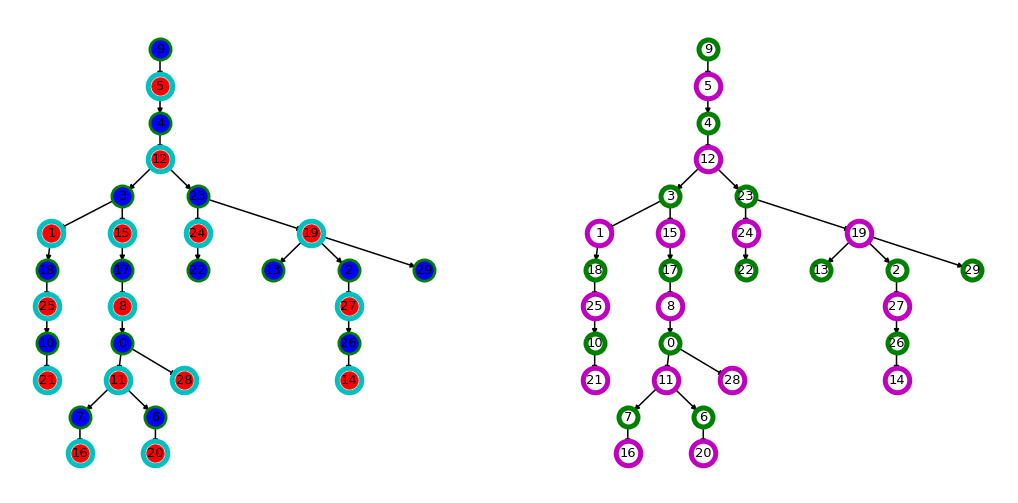

In [15]:
plot_encoding_tree(t, figsize)

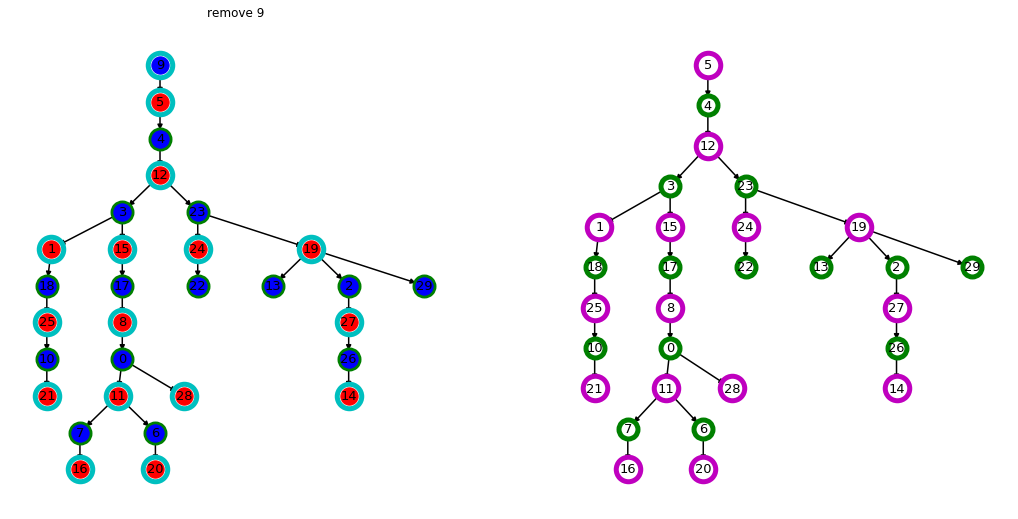

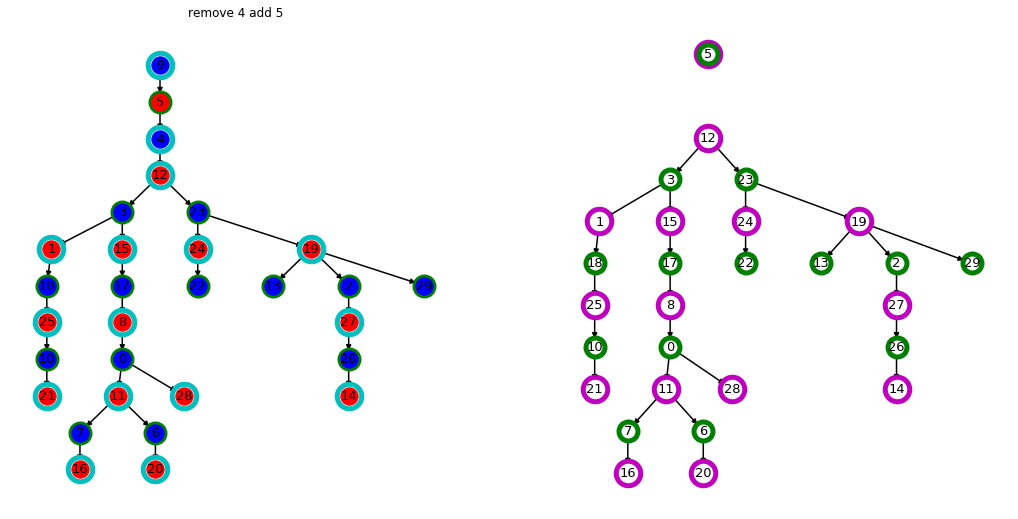

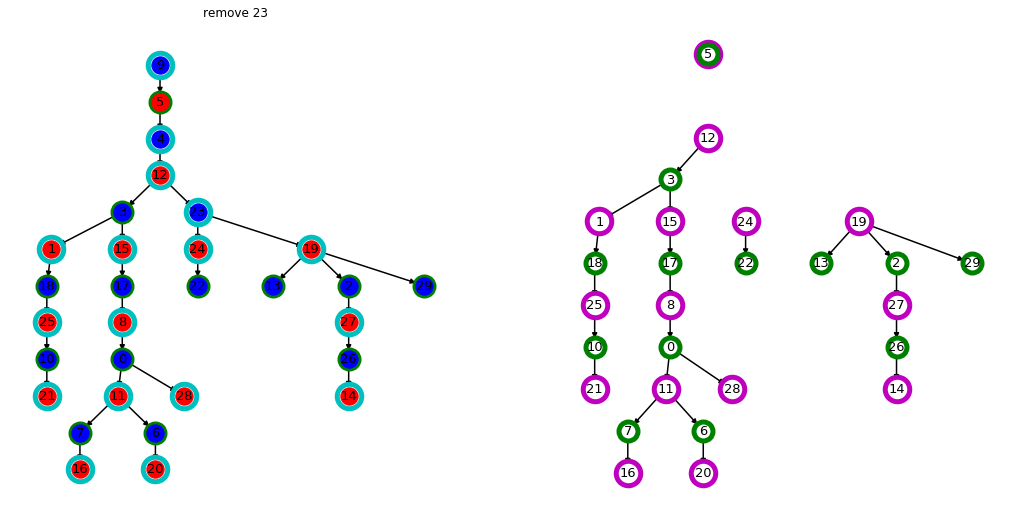

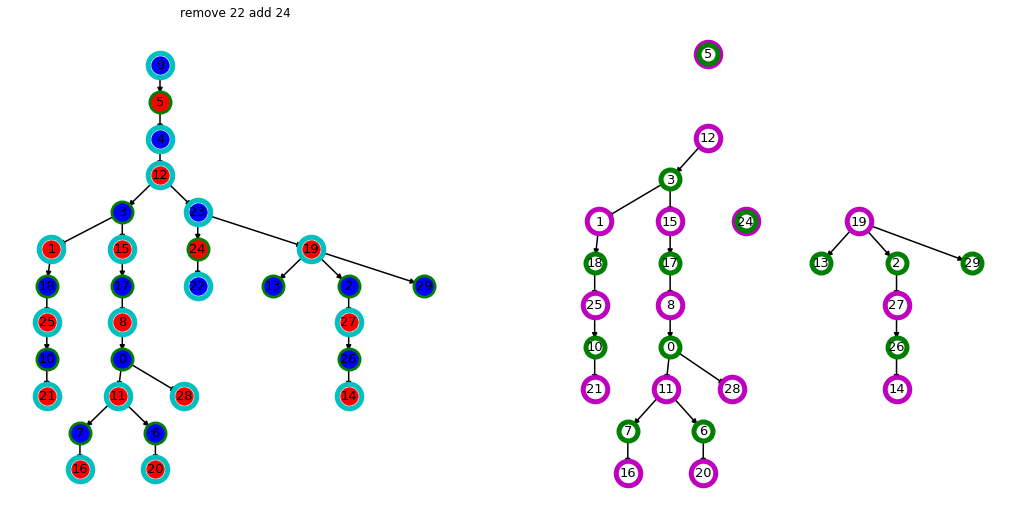

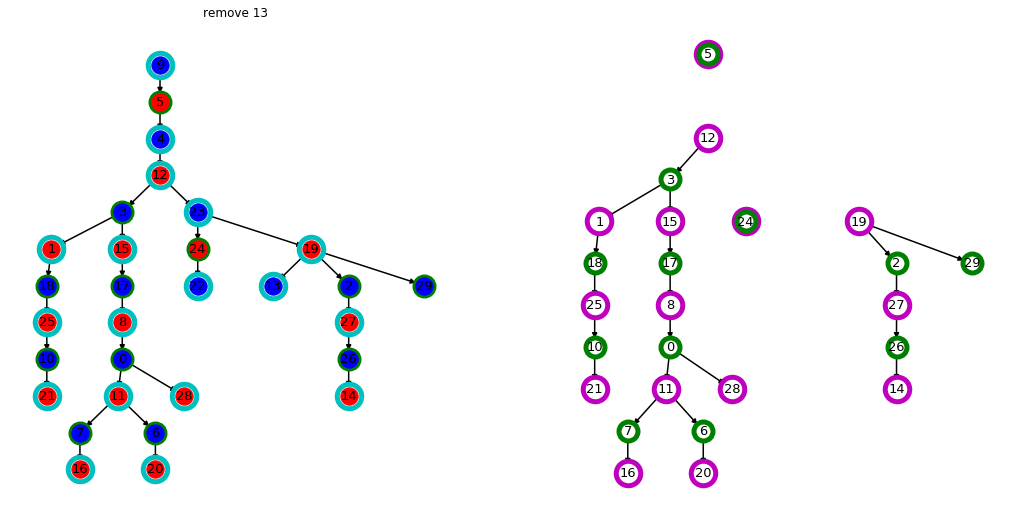

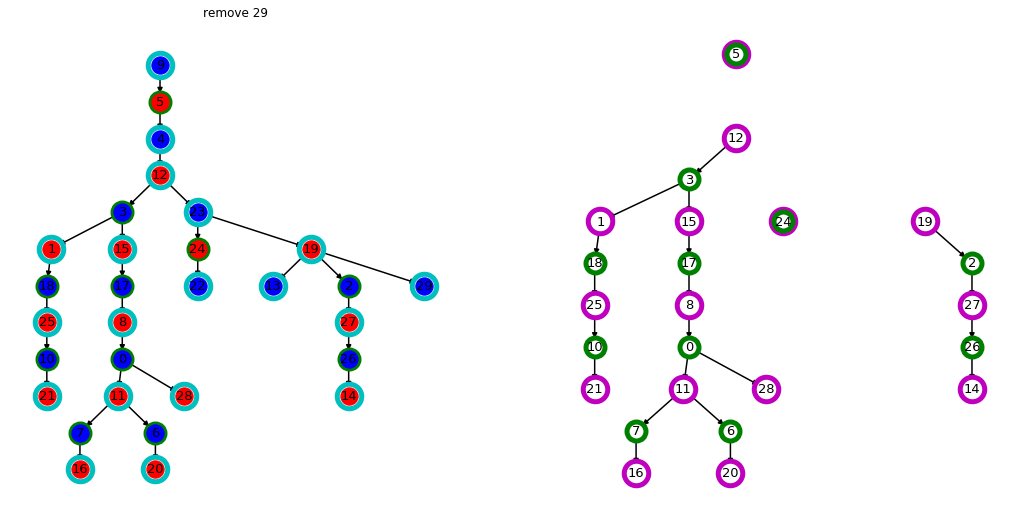

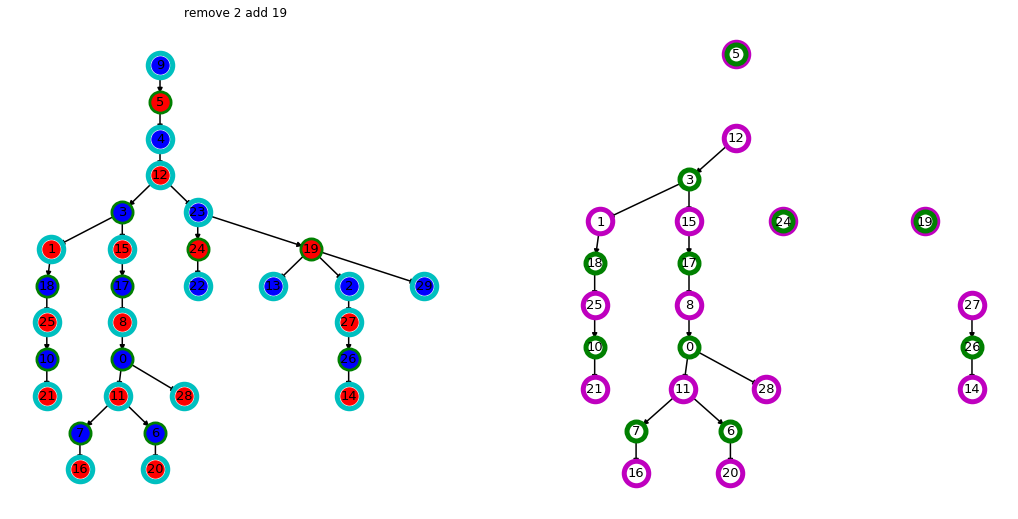

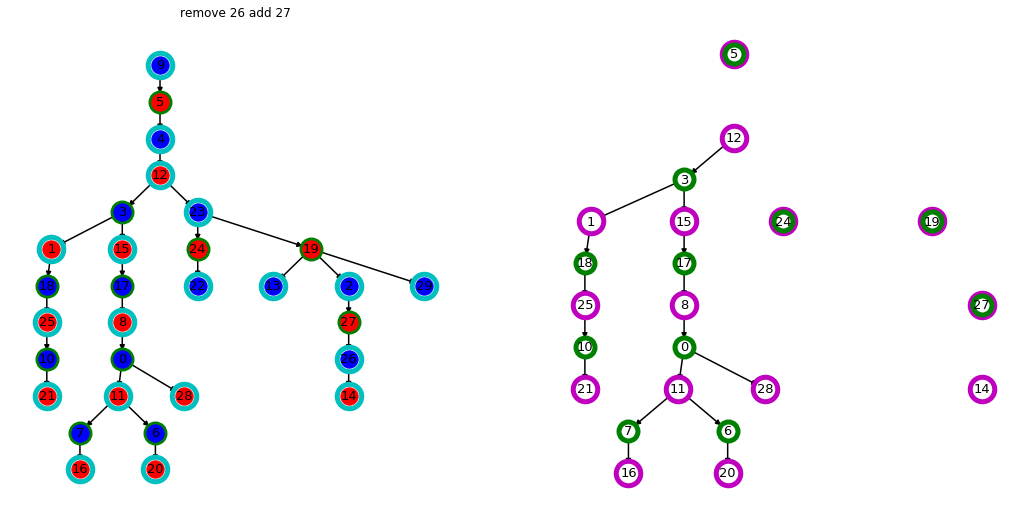

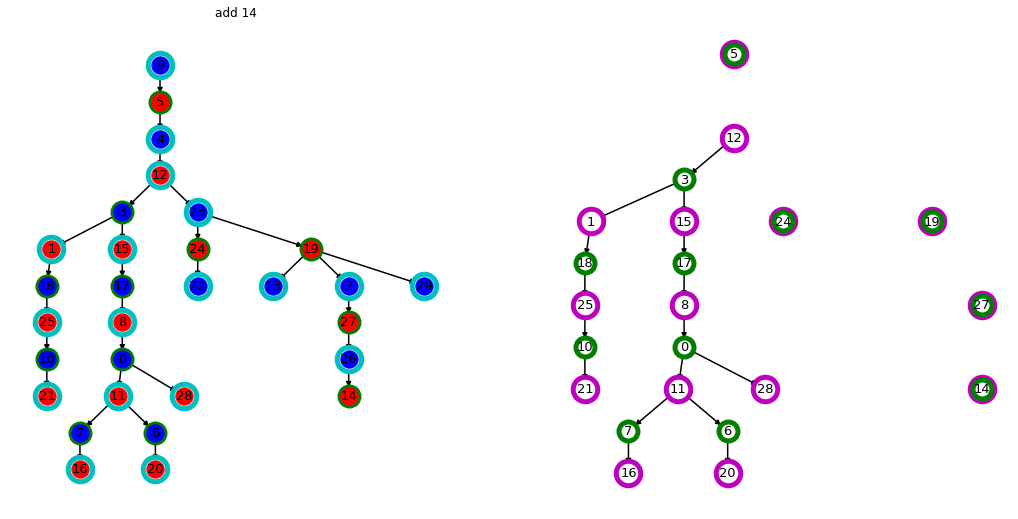

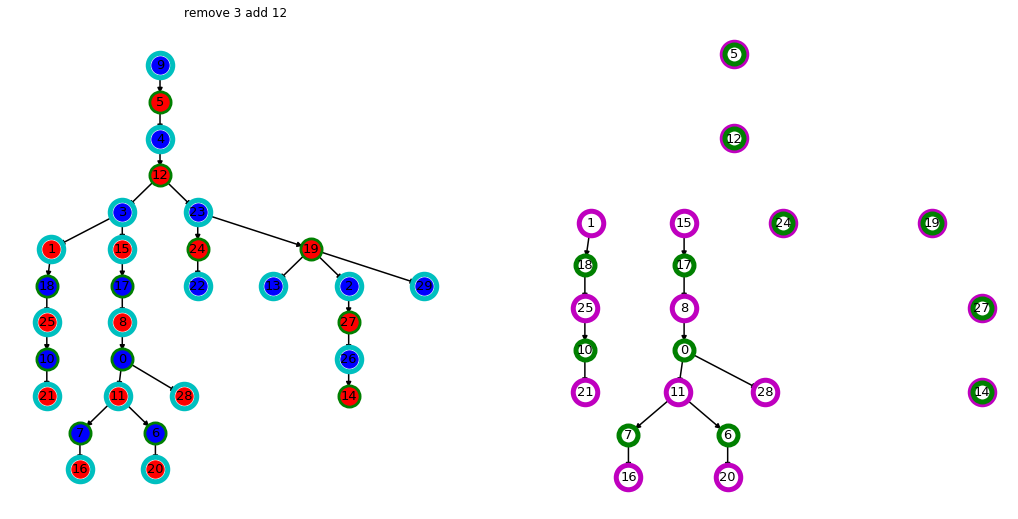

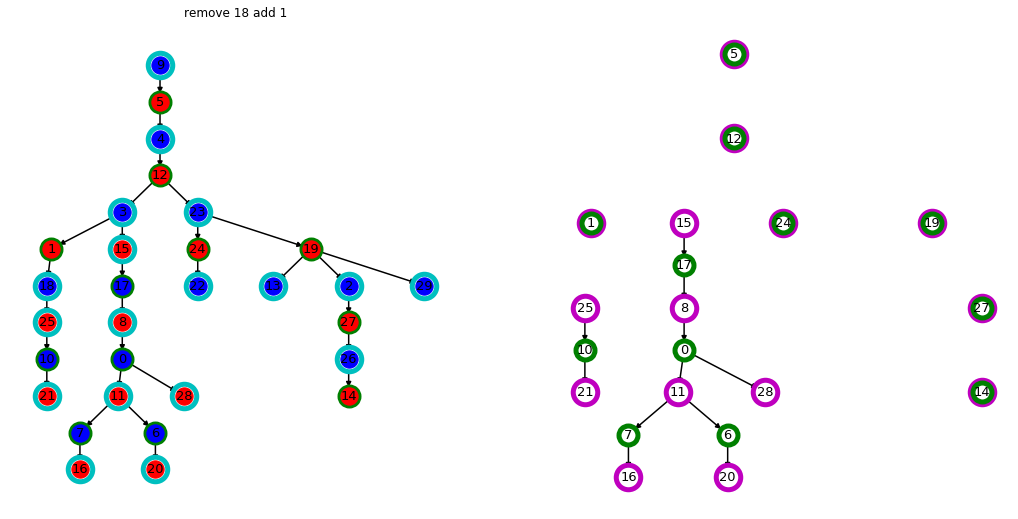

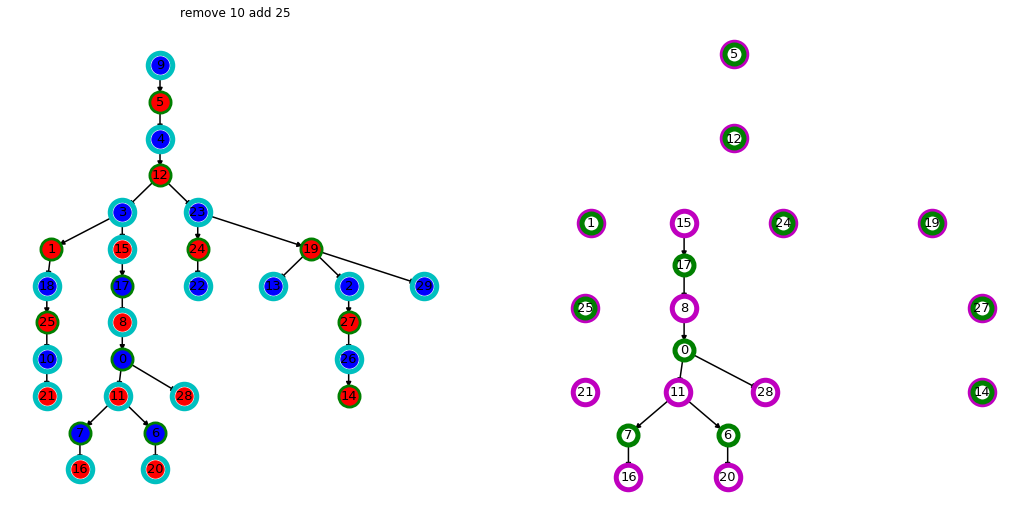

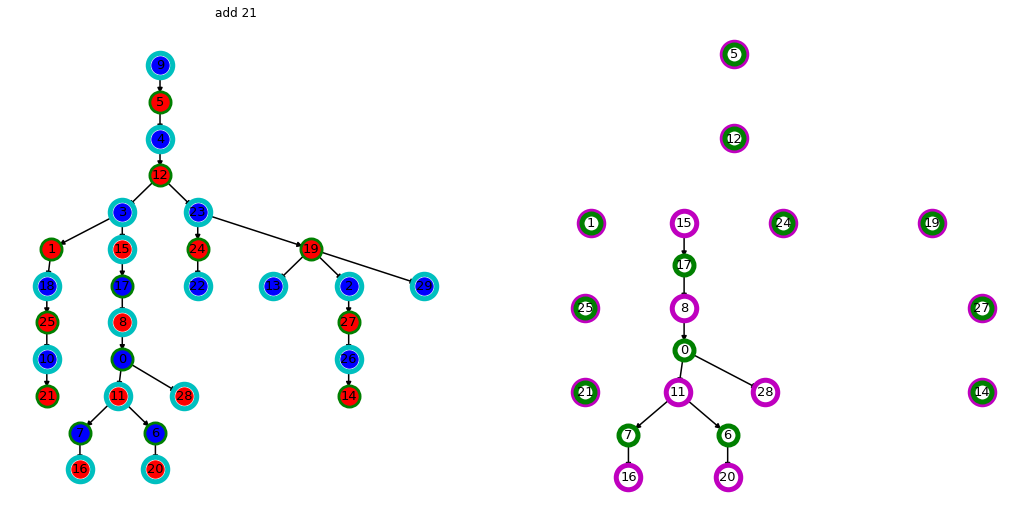

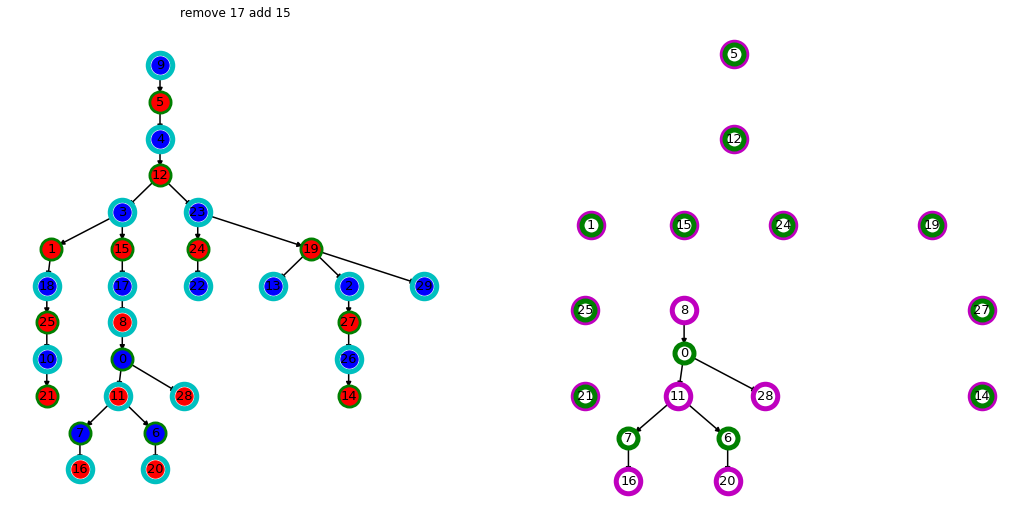

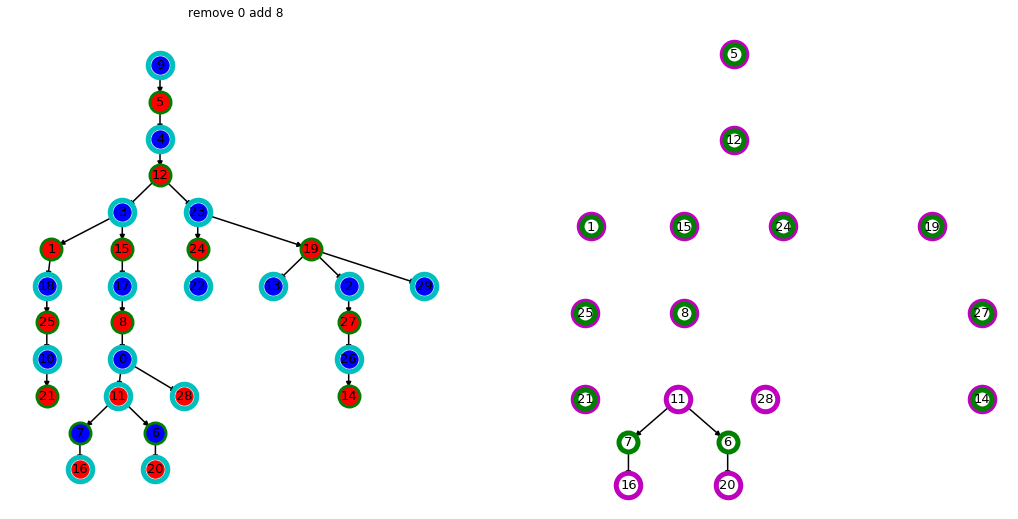

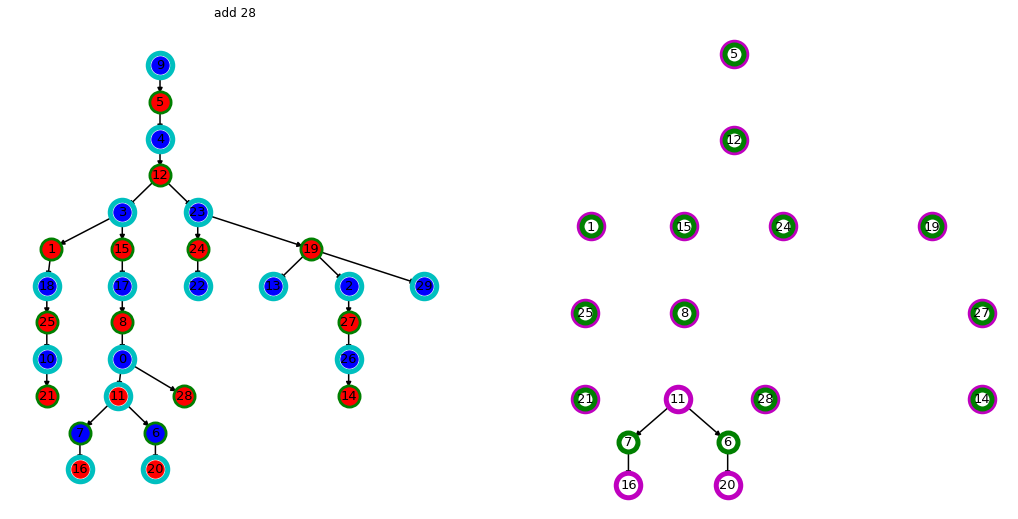

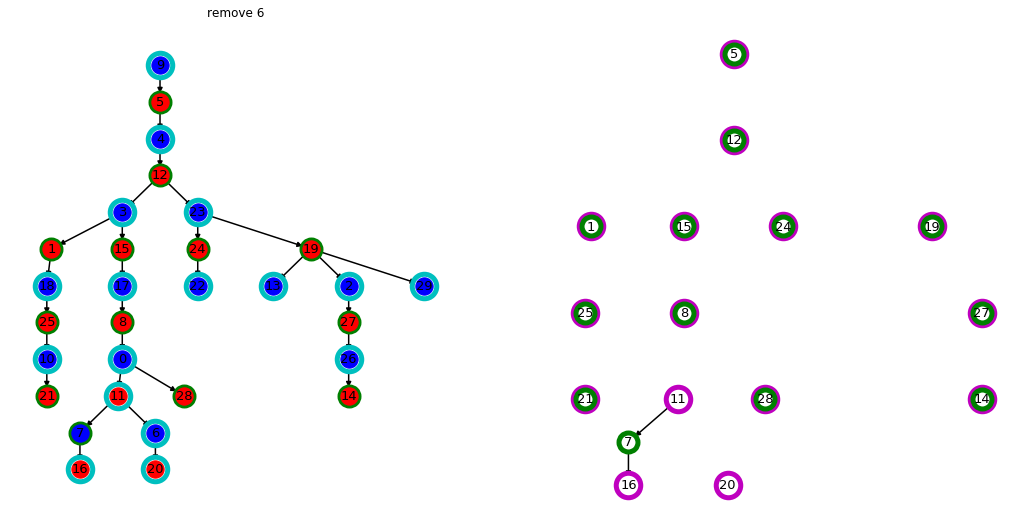

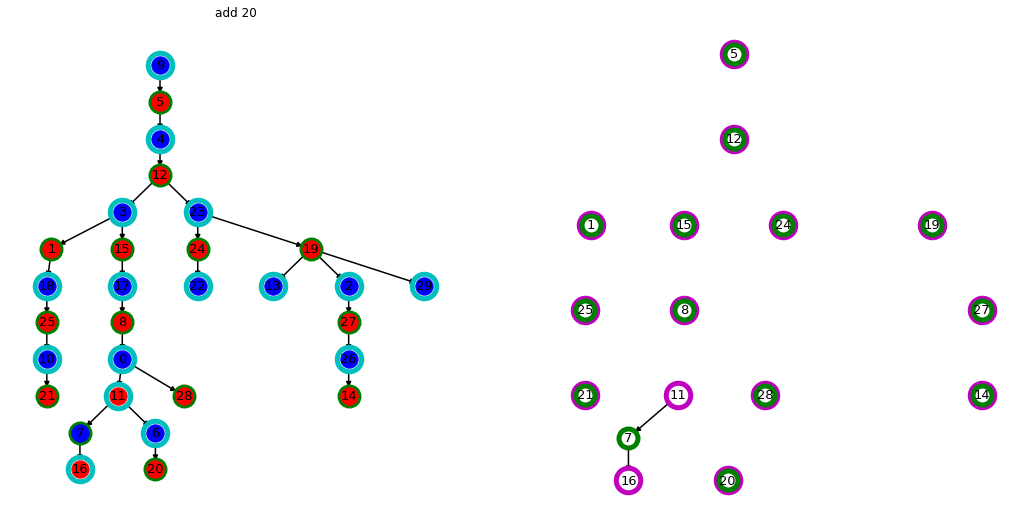

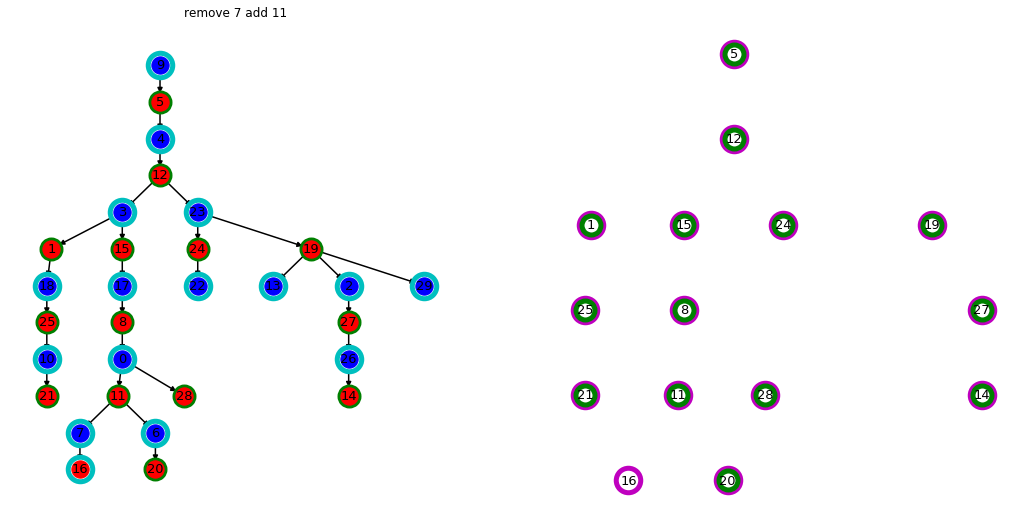

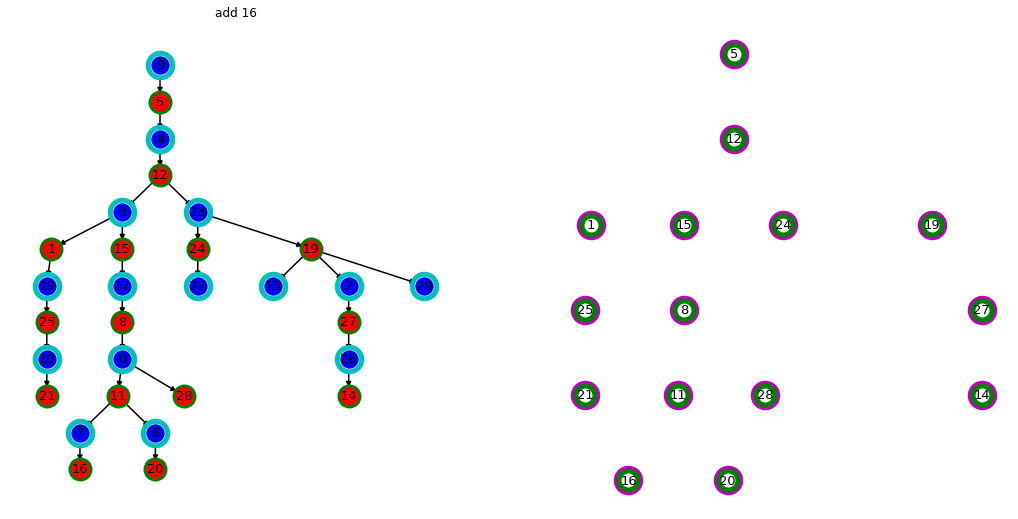

In [16]:
ct = nx.DiGraph(t)
process(ct, root, figsize)

In [ ]:
### order is a very important problem